# Урок 8. Python применение статистических критериев на практике - пайплайн оценки A/B

На сайте запущен А/В тест с целью увеличить доход.  
В приложенном excel файле вы найдете сырые данные  
по результатам эксперимента – user_id,  
тип выборки variant_name  
и доход принесенный пользователем revenue.

Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

In [32]:
from scipy.stats import ttest_1samp
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import kstest
from scipy.stats import mannwhitneyu
from scipy.stats import norm
import pandas as pd

import matplotlib.pyplot as plt
from importlib import import_module

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [21]:
data = pd.read_excel('AB_Test_Results.xlsx')
data.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [23]:
data.shape

(10000, 3)

In [24]:
data.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [25]:
data.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [26]:
new_data = data[data['REVENUE'] > 0]
new_data

,USER_ID,VARIANT_NAME,REVENUE
13,2529,variant,2.15
49,6429,control,3.25
139,3331,variant,4.27
149,8110,variant,1.75
152,8607,control,2.99
...,...,...,...
9651,9928,variant,1.25
9711,6468,control,2.93
9724,5205,control,14.17
9725,702,variant,2.92


In [27]:
new_data[data['VARIANT_NAME']=='variant'].describe()

,USER_ID,REVENUE
count,72.000000,72.000000
mean,5306.958333,4.881528
std,3116.544256,9.913973
min,56.000000,0.020000
25%,2707.500000,1.245000
50%,5721.000000,2.170000
75%,7963.750000,3.972500
max,9996.000000,58.630000


In [28]:
new_data[data['VARIANT_NAME']=='control'].describe()

,USER_ID,REVENUE
count,80.000000,80.000000
mean,4461.950000,8.037500
std,2826.386242,22.498124
min,124.000000,0.020000
25%,2037.500000,1.515000
50%,4327.000000,2.960000
75%,6636.750000,6.657500
max,9766.000000,196.010000


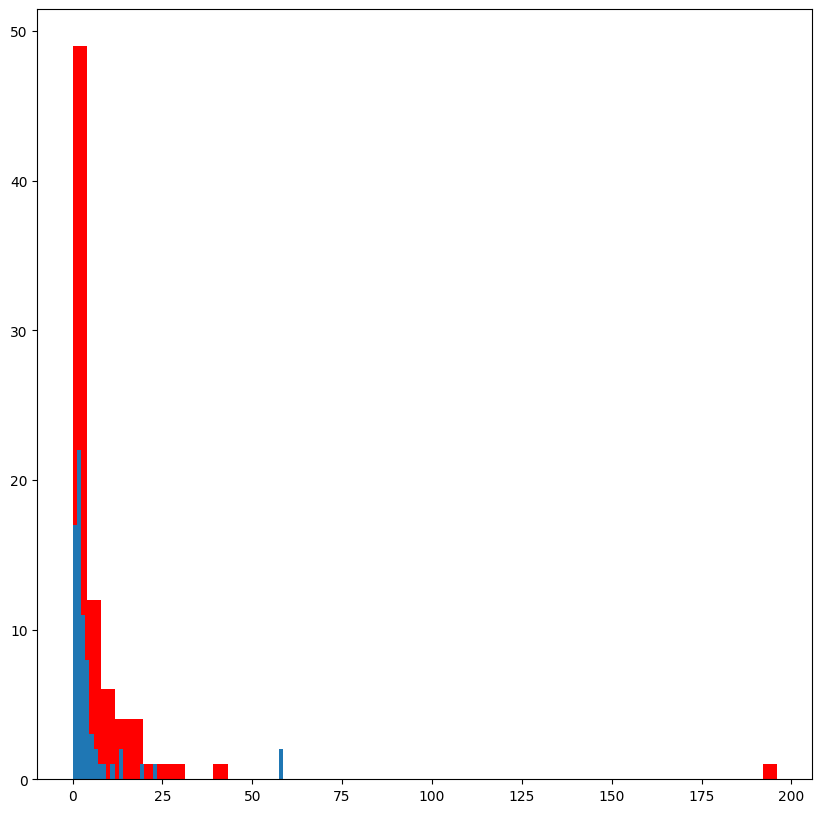

In [33]:
plt.figure(figsize=(10, 10))
control_visit_all = new_data['REVENUE'][data['VARIANT_NAME']=='control']
test_visit_all = new_data['REVENUE'][data['VARIANT_NAME']=='variant']

plt.hist(control_visit_all, color='r', bins=50)
plt.hist(test_visit_all, bins=50)

plt.show()

In [34]:
ttest_ind(control_visit_all, test_visit_all, equal_var = False)

TtestResult(statistic=1.1379124979933528, pvalue=0.25760685398932337, df=111.01658223881753)

pvalue > 0.05  
Значимых изменений нет

In [35]:
print(kstest(control_visit_all, 'norm'))
print(kstest(test_visit_all, 'norm'))

KstestResult(statistic=0.7443502263331446, pvalue=3.476934093734831e-46, statistic_location=1.25, statistic_sign=-1)
KstestResult(statistic=0.6885669682907651, pvalue=1.5788521734348762e-34, statistic_location=1.0, statistic_sign=-1)


pvalue < 0.05  
Отвергаем нулевую гипотезу данные распределенны не нормально

In [36]:
mannwhitneyu(control_visit_all, test_visit_all)

MannwhitneyuResult(statistic=3356.0, pvalue=0.07924299810603061)

pvalue > 0.05  
Принимаем 0 гипотезу значемых изменений нет

In [38]:
def get_bootstrap(
    data_column_1,
    data_column_2,
    boot_it = 1000,
    statistic = np.mean,
    bootstrap_conf_level = 0.95
    ):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True
            ).values
        
        samples_2 = data_column_2.sample(
            boot_len,
            replace = True
            ).values

        boot_data.append(statistic(samples_1)-statistic(samples_2))
    pd_boot_data = pd.DataFrame(boot_data)

        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('Значение метрики')
    plt.ylabel('Частота')
    plt.title("Гистограмма распределения")
    plt.show()
       
    return {"quants": quants, 
            "p_value": p_value}


In [44]:
plt.style.use('seaborn')
pd.options.display.float_format = '{:,.2f}'.format

booted_data = get_bootstrap(data['REVENUE'][data['VARIANT_NAME']=='control'],
                            data['REVENUE'][data['VARIANT_NAME']=='variant'],
                            boot_it = 10000)

print('p_value', booted_data['p_value'])

NameError: name 'tqdm' is not defined

p_value > 0.05  
Нет статистической значимости  

Ответ: победил контрол раскатывать тест не нужно